In [13]:
from time import sleep
from datetime import datetime
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import os
import pickle
import ast
import shap
import matplotlib.pyplot as plt
from joblib import dump, load
%matplotlib inline

In [14]:
def compute_relative_effectiveness(ident, acc, base_ident, base_acc):
    numerator = ident - base_ident
    denominator = acc - base_acc
    if denominator == 0:
        return np.nan  # Avoid division by zero
    return np.log(numerator / denominator)

def plot_both_accuracies(score_list, legend_name):
    releff_list = [
        compute_relative_effectiveness(row[2], row[1], base_ident, base_acc) 
        for row in score_list
    ]
        
    plt.figure(figsize=(10, 6))

    plt.plot(score_list[:, 0], releff_list, 'ro', label=legend_name)
#     plt.scatter(1-score_list[:, 2], score_list[:, 1])

    plt.title(f'Relative Effectiveness vs. Number of Features')
    plt.xlabel('Number of Features')
    plt.ylabel('Relative Effectiveness')
    # plt.ylim(0, 1.1)
    # plt.xlim(0, 1.1)

    # Adding a legend
    plt.legend()

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.savefig(f'{legend_name}.png')
    plt.show()

In [15]:
df_X_train = pd.read_csv("../X_train_by_subnet.csv")
df_Y_train = pd.read_csv("../Y_train_by_subnet.csv")
df_X_test = pd.read_csv("../X_test_by_subnet.csv")
df_Y_test = pd.read_csv("../Y_test_by_subnet.csv")

In [16]:
rfc_act = RandomForestClassifier(random_state=42)
rfc_act.fit(df_X_train, df_Y_train.iloc[:, 0].to_numpy())

rfc_threat = RandomForestClassifier(random_state=42)
rfc_threat.fit(df_X_train, df_Y_train.iloc[:, 1].to_numpy())

threat_pred = rfc_threat.predict(df_X_test)
act_pred = rfc_act.predict(df_X_test)

threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), threat_pred)  # Source IP re-id classifier (Threat)
act_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred) # Network Intrusion classifier

base_ident = threat_score
base_acc = act_score
base_acc, base_ident

(0.9798257679963319, 0.5767996331957818)

In [3]:
base_acc, base_ident = (0.9798257679963319, 0.5767996331957818)

In [4]:
df_X_train.shape

(5086, 74)

In [5]:
df_Y_train.shape

(5086, 3)

In [6]:
df_X_test.shape

(2181, 74)

In [7]:
df_X_train.columns.tolist()

['Flow Duration',
 'Total Fwd Packets',
 'Total Backward Packets',
 'Total Length of Fwd Packets',
 'Total Length of Bwd Packets',
 'Fwd Packet Length Max',
 'Fwd Packet Length Min',
 'Fwd Packet Length Mean',
 'Fwd Packet Length Std',
 'Bwd Packet Length Max',
 'Bwd Packet Length Min',
 'Bwd Packet Length Mean',
 'Bwd Packet Length Std',
 'Flow Bytes/s',
 'Flow Packets/s',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Flow IAT Min',
 'Fwd IAT Total',
 'Fwd IAT Mean',
 'Fwd IAT Std',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Bwd IAT Total',
 'Bwd IAT Mean',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd IAT Min',
 'Fwd PSH Flags',
 'Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'Fwd Header Length',
 'Bwd Header Length',
 'Fwd Packets/s',
 'Bwd Packets/s',
 'Min Packet Length',
 'Max Packet Length',
 'Packet Length Mean',
 'Packet Length Std',
 'Packet Length Variance',
 'FIN Flag Count',
 'SYN Flag Count',
 'RST Flag Count',
 'PSH Flag Count',
 'ACK Flag Count',
 'URG Flag Count',
 'CWE 

In [8]:
df_Y_train

,0,1,2
0,1,194,370
1,0,300,360
2,0,294,368
3,0,304,246
4,1,194,370
...,...,...,...
5081,0,305,882
5082,0,293,1142
5083,0,296,1177
5084,0,300,360


In [9]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.datasets import load_iris
from scipy.stats import entropy
import numpy as np

# Compute mutual information for utility score
utility_scores = mutual_info_classif(df_X_train.to_numpy(), df_Y_train.iloc[:, 0].to_numpy())
print("Utility Scores (Mutual Information):", utility_scores)

# Function to compute the entropy of a feature
def compute_feature_entropy(feature):
    p, _ = np.histogram(feature, bins=10, density=True)
    p = p[p > 0]  # Remove zero entries to avoid log(0) issues
    return entropy(p)

# Function to compute privacy scores
def compute_privacy_scores(X):
    privacy_scores = []
    original_entropies = [compute_feature_entropy(X[:, i]) for i in range(X.shape[1])]
    total_original_entropy = sum(original_entropies)

    for i in range(X.shape[1]):
        # Compute the entropy of the dataset without the i-th feature
        sanitized_entropies = original_entropies[:i] + original_entropies[i+1:]
        total_sanitized_entropy = sum(sanitized_entropies)
        # Privacy score is the decrease in entropy
        privacy_score = total_original_entropy - total_sanitized_entropy
        privacy_scores.append(privacy_score)
    return privacy_scores

# Compute privacy scores
privacy_scores = compute_privacy_scores(df_X_train.to_numpy())
print("Privacy Scores (Entropy-Based):", privacy_scores)


# Normalize scores for combining
utility_scores_normalized = np.array(utility_scores) / np.max(utility_scores)
privacy_scores_normalized = np.array(privacy_scores) / np.max(privacy_scores)

# Combine utility and privacy scores to compute trade-off scores
def trade_off_score(utility_scores, privacy_scores):
    return [(u + p) / 2 for u, p in zip(utility_scores_normalized, privacy_scores_normalized)]

# Compute trade-off scores
trade_off_scores = trade_off_score(utility_scores, privacy_scores)
print("Trade-Off Scores:", trade_off_scores)


Utility Scores (Mutual Information): [0.4224619  0.36508791 0.22894622 0.41499153 0.31470711 0.41656069
 0.24483224 0.41646294 0.10271084 0.32051309 0.19747135 0.3011777
 0.07333561 0.39707144 0.44967906 0.43796214 0.43023114 0.44002324
 0.40144763 0.40145162 0.4296189  0.39898652 0.41078997 0.48469387
 0.19426551 0.19495896 0.06702794 0.18983475 0.14514721 0.00946617
 0.0039788  0.         0.00191788 0.46227287 0.27736593 0.44652207
 0.4232642  0.2370917  0.42094    0.41328146 0.28543721 0.27570855
 0.00791828 0.01325329 0.00215875 0.2266985  0.0242046  0.02119995
 0.         0.00209821 0.14263753 0.41667842 0.41952283 0.29804506
 0.00586794 0.         0.0034313  0.00469448 0.         0.
 0.37343179 0.41097432 0.22830495 0.30431489 0.20839816 0.19888506
 0.04103401 0.02427459 0.04215419 0.04409867 0.04466275 0.03068025
 0.03714155 0.04562688]
Privacy Scores (Entropy-Based): [0.5304636537109584, 0.01663037264778211, 0.012303583598486156, 0.08000981751130176, 0.015287665201473288, 0.038

In [10]:
# Function to remove features with the lowest n scores
def remove_lowest_features(X, scores, n):
    # Get the indices of the features sorted by score
    sorted_indices = np.argsort(scores)
    # Get the indices of the features to remove
    indices_to_remove = sorted_indices[:n]
    # Remove the features from X
    X_modified = np.delete(X, indices_to_remove, axis=1)
    return X_modified


100%|███████████████████████████████████████████████████████████████████████████████████| 73/73 [09:36<00:00,  7.89s/it]
/tmp/ipykernel_419936/1236790252.py:6: RuntimeWarning: invalid value encountered in log
  return np.log(numerator / denominator)
/tmp/ipykernel_419936/1236790252.py:6: RuntimeWarning: divide by zero encountered in log
  return np.log(numerator / denominator)


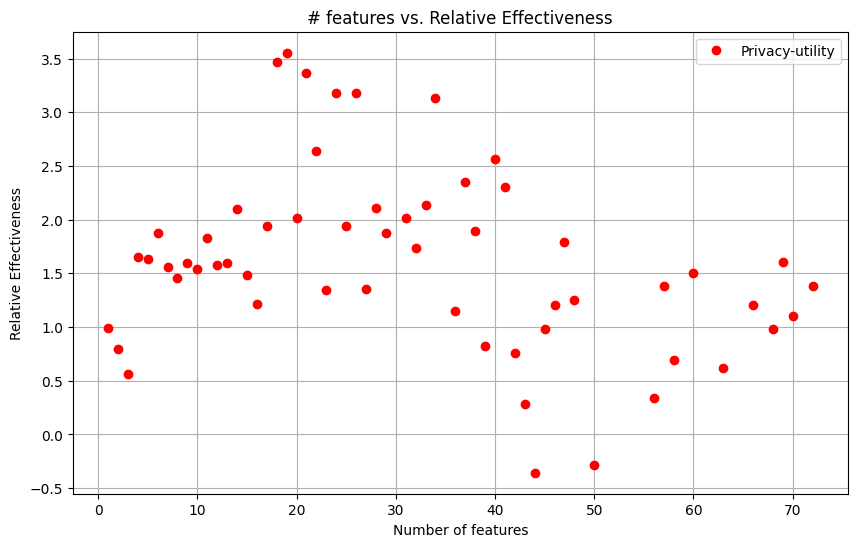

In [17]:
# Privacy-utility score
score_list = []
from tqdm import tqdm
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")
    for n_to_remove in tqdm(range(1, len(trade_off_scores))):
        opt_df_X_train = remove_lowest_features(df_X_train.to_numpy(), trade_off_scores, n_to_remove)
        opt_df_X_test = remove_lowest_features(df_X_test.to_numpy(), trade_off_scores, n_to_remove)
    
        rfc_act = RandomForestClassifier()
        rfc_act.fit(opt_df_X_train, df_Y_train.iloc[:, 0].to_numpy())

        rfc_threat = RandomForestClassifier()
        rfc_threat.fit(opt_df_X_train, df_Y_train.iloc[:, 1].to_numpy())

        threat_pred = rfc_threat.predict(opt_df_X_test)
        act_pred = rfc_act.predict(opt_df_X_test)

        threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), threat_pred)  # Source IP re-id classifier (Threat)
        act_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred) # Network Intrusion classifier
        score_list.append([opt_df_X_train.shape[1], act_score, threat_score])

np.savetxt(f'privacy-utility.csv', np.array(score_list), delimiter=",")
plot_both_accuracies(np.array(score_list), 'Privacy-utility')

100%|███████████████████████████████████████████████████████████████████████████████████| 73/73 [08:11<00:00,  6.74s/it]
/tmp/ipykernel_419936/1236790252.py:6: RuntimeWarning: invalid value encountered in log
  return np.log(numerator / denominator)


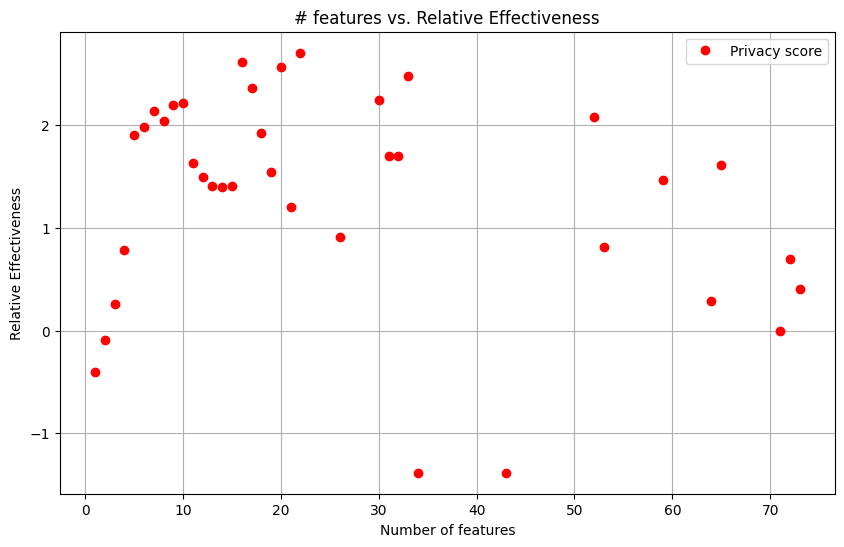

In [18]:
# Privacy score
score_list = []
from tqdm import tqdm
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")
    for n_to_remove in tqdm(range(1, len(privacy_scores))):
        opt_df_X_train = remove_lowest_features(df_X_train.to_numpy(), privacy_scores, n_to_remove)
        opt_df_X_test = remove_lowest_features(df_X_test.to_numpy(), privacy_scores, n_to_remove)
    
        rfc_act = RandomForestClassifier()
        rfc_act.fit(opt_df_X_train, df_Y_train.iloc[:, 0].to_numpy())

        rfc_threat = RandomForestClassifier()
        rfc_threat.fit(opt_df_X_train, df_Y_train.iloc[:, 1].to_numpy())

        threat_pred = rfc_threat.predict(opt_df_X_test)
        act_pred = rfc_act.predict(opt_df_X_test)

        threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), threat_pred)  # Source IP re-id classifier (Threat)
        act_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred) # Network Intrusion classifier
        score_list.append([opt_df_X_train.shape[1], act_score, threat_score])

np.savetxt(f'privacy-score.csv', np.array(score_list), delimiter=",")
plot_both_accuracies(np.array(score_list), 'Privacy score')

In [ ]:
# Feature utility score
score_list = []
from tqdm import tqdm
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")
    for n_to_remove in tqdm(range(1, len(utility_scores))):
        opt_df_X_train = remove_lowest_features(df_X_train.to_numpy(), utility_scores, n_to_remove)
        opt_df_X_test = remove_lowest_features(df_X_test.to_numpy(), utility_scores, n_to_remove)
    
        rfc_act = RandomForestClassifier()
        rfc_act.fit(opt_df_X_train, df_Y_train.iloc[:, 0].to_numpy())

        rfc_threat = RandomForestClassifier()
        rfc_threat.fit(opt_df_X_train, df_Y_train.iloc[:, 1].to_numpy())

        threat_pred = rfc_threat.predict(opt_df_X_test)
        act_pred = rfc_act.predict(opt_df_X_test)

        threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), threat_pred)  # Source IP re-id classifier (Threat)
        act_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred) # Network Intrusion classifier
        score_list.append([opt_df_X_train.shape[1], act_score, threat_score])

np.savetxt(f'utility-score.csv', np.array(score_list), delimiter=",")
plot_both_accuracies(np.array(score_list), 'Utility score')

 66%|██████████████████████████████████████████████████████▌                            | 48/73 [07:14<03:57,  9.52s/it]

In [ ]:
from sklearn.feature_extraction import FeatureHasher

def feature_hashing(df, n_features):
    # Convert DataFrame to a list of dictionaries
    data_dict = df.to_dict(orient='records')

    # Initialize FeatureHasher
    hasher = FeatureHasher(n_features=n_features, input_type='dict')

    # Transform data
    hashed_features = hasher.transform(data_dict).toarray()

    # Convert hashed features to DataFrame if needed
    hashed_df = pd.DataFrame(hashed_features)
    return hashed_df

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

def pca_reduction(df, n_components):
    # Standardize the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df)
    
    # Initialize PCA
    pca = PCA(n_components=n_components)
    
    # Fit and transform the data
    pca_features = pca.fit_transform(scaled_features)
    
    # Convert PCA features to DataFrame
    pca_df = pd.DataFrame(pca_features)
    return pca_df


In [ ]:
# Feature hashing
score_list = []
from tqdm import tqdm
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")
    for n_features in tqdm(range(3,51)):
        hashed_X_train = feature_hashing(df_X_train, n_features)
        hashed_X_test = feature_hashing(df_X_test, n_features)

        rfc_act = RandomForestClassifier()
        rfc_act.fit(hashed_X_train.to_numpy(), df_Y_train.iloc[:, 0].to_numpy())

        rfc_threat = RandomForestClassifier()
        rfc_threat.fit(hashed_X_train.to_numpy(), df_Y_train.iloc[:, 1].to_numpy())

        threat_pred = rfc_threat.predict(hashed_X_test)
        act_pred = rfc_act.predict(hashed_X_test)

        threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), threat_pred)  # Source IP re-id classifier (Threat)
        act_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred) # Network Intrusion classifier
        score_list.append([n_features, act_score, threat_score])

np.savetxt(f'feature_hashing.csv', np.array(score_list), delimiter=",")
plot_both_accuracies(np.array(score_list), 'Feature hashing')

In [1]:
score_list_np = np.loadtxt(f'feature_hashing.csv', delimiter=",")
plot_both_accuracies(score_list_np, 'Feature hashing')

NameError: name 'np' is not defined

100%|███████████████████████████████████████████████████████████████████████████████████| 48/48 [12:05<00:00, 15.11s/it]


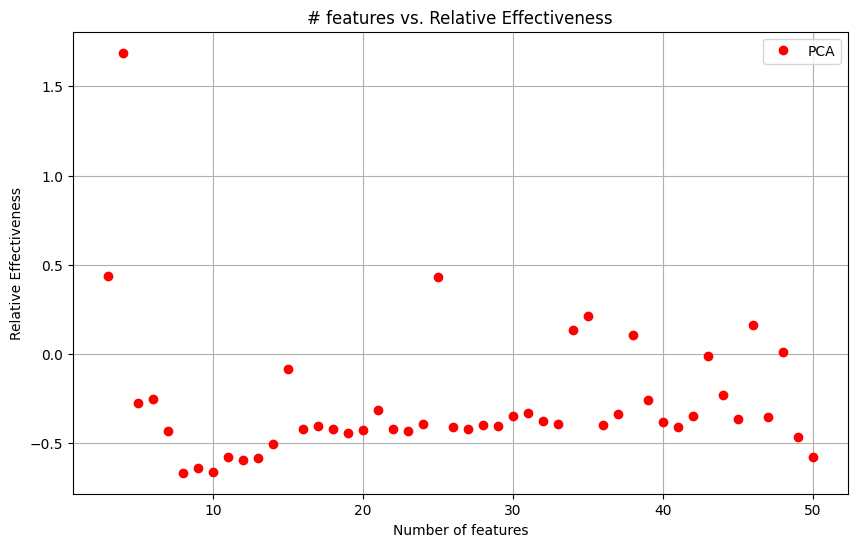

In [26]:
# PCA dimensionality reduction
score_list = []
from tqdm import tqdm
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")
    for n_features in tqdm(range(3,51)):
        reduced_X_train = pca_reduction(df_X_train, n_features)
        reduced_X_test = pca_reduction(df_X_test, n_features)

        rfc_act = RandomForestClassifier()
        rfc_act.fit(reduced_X_train.to_numpy(), df_Y_train.iloc[:, 0].to_numpy())

        rfc_threat = RandomForestClassifier()
        rfc_threat.fit(reduced_X_train.to_numpy(), df_Y_train.iloc[:, 1].to_numpy())

        threat_pred = rfc_threat.predict(reduced_X_test)
        act_pred = rfc_act.predict(reduced_X_test)

        threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), threat_pred)  # Source IP re-id classifier (Threat)
        act_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred) # Network Intrusion classifier
        score_list.append([reduced_X_train.shape[1], act_score, threat_score])

np.savetxt(f'pca_reduction.csv', np.array(score_list), delimiter=",")
plot_both_accuracies(np.array(score_list), 'PCA')

In [27]:
def add_laplace_noise(df, epsilon):
    # Define the scale of the Laplace noise
    scale = 1.0 / epsilon
    
    # Create a noise matrix with the same shape as the DataFrame
    noise = np.random.laplace(loc=0, scale=scale, size=df.shape)
    
    # Add the noise to the original DataFrame
    noisy_df = df + noise
    
    # Convert the result back to a DataFrame
    noisy_df = pd.DataFrame(noisy_df, columns=df.columns)
    return noisy_df

100%|█████████████████████████████████████████████████████████████████████████████████████| 9/9 [04:26<00:00, 29.58s/it]
/tmp/ipykernel_419936/1236790252.py:6: RuntimeWarning: invalid value encountered in log
  return np.log(numerator / denominator)


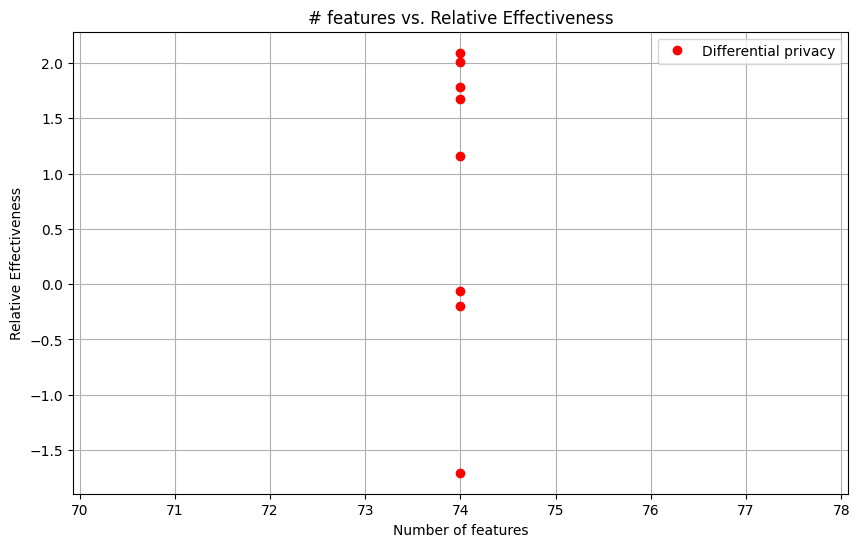

In [28]:
# Differential privacy: laplace noise
score_list = []
from tqdm import tqdm
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")
    for epsilon in tqdm([0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]):
        noisy_X_train = add_laplace_noise(df_X_train, epsilon)
        noisy_X_test = add_laplace_noise(df_X_test, epsilon)

        rfc_act = RandomForestClassifier()
        rfc_act.fit(noisy_X_train, df_Y_train.iloc[:, 0].to_numpy())

        rfc_threat = RandomForestClassifier()
        rfc_threat.fit(noisy_X_train, df_Y_train.iloc[:, 1].to_numpy())

        threat_pred = rfc_threat.predict(noisy_X_test)
        act_pred = rfc_act.predict(noisy_X_test)

        threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), threat_pred)  # Source IP re-id classifier (Threat)
        act_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred) # Network Intrusion classifier
        score_list.append([noisy_X_train.shape[1], act_score, threat_score])

np.savetxt(f'differential_privacy.csv', np.array(score_list), delimiter=",")
plot_both_accuracies(np.array(score_list), 'Differential privacy')

In [17]:
from sklearn.metrics import accuracy_score
from joblib import dump, load
def get_accuracy_for_both_models(perc, df_X_train, df_X_test, df_Y_train, df_Y_test, threat_model_fi, source_model_fi):
    ratio = threat_model_fi / (1+source_model_fi)
    ratio = ratio[~np.isnan(ratio)]
    max_finite = np.max(ratio[np.isfinite(ratio)])
    ratio[ratio == np.inf] = max_finite
    threshold = np.percentile(ratio, 100-perc)
    if perc == 100:
        threshold = 0 # np.inf
    print("Both score:", ratio)
    feat_idx = np.where(threat_model_fi / (1+source_model_fi) >= threshold)[0]
    print("Features for both:", feat_idx)
    print(f"Percentile of features to keep: {perc}; Number of features to keep: {len(feat_idx)}; Ratio Threshold: {threshold}")
    new_train = df_X_train[:, feat_idx]
    new_test = df_X_test[:, feat_idx]
    
    new_threat_model = RandomForestClassifier(random_state=42)
    new_threat_model.fit(new_train, df_Y_train.iloc[:, 1].to_numpy())

    new_source_model = RandomForestClassifier(random_state=42)
    new_source_model.fit(new_train, df_Y_train.iloc[:, 0].to_numpy())

    ip_pred_new = new_threat_model.predict(new_test)
    act_pred_new = new_source_model.predict(new_test)
    
    threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)  # Source IP re-id classifier (Threat)
    y_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new) # Network Intrusion classifier

    return len(feat_idx), threat_score, y_score


def get_accuracy_for_source_models(perc, df_X_train, df_X_test, df_Y_train, df_Y_test, threat_model_fi, source_model_fi):
    ratio = source_model_fi
    ratio = ratio[~np.isnan(ratio)]
    max_finite = np.max(ratio[np.isfinite(ratio)])
    ratio[ratio == np.inf] = max_finite
    threshold = np.percentile(ratio, 100-perc)
    if perc == 100:
        threshold = 0 # np.inf
    print("Both score:", ratio)
    feat_idx = np.where(source_model_fi >= threshold)[0]
    print("Features for both:", feat_idx)
    print(f"Percentile of features to keep: {perc}; Number of features to keep: {len(feat_idx)}; Ratio Threshold: {threshold}")
    new_train = df_X_train[:, feat_idx]
    new_test = df_X_test[:, feat_idx]
    
    new_threat_model = RandomForestClassifier(random_state=42)
    new_threat_model.fit(new_train, df_Y_train.iloc[:, 1].to_numpy())

    new_source_model = RandomForestClassifier(random_state=42)
    new_source_model.fit(new_train, df_Y_train.iloc[:, 0].to_numpy())

    ip_pred_new = new_threat_model.predict(new_test)
    act_pred_new = new_source_model.predict(new_test)
    
    threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)  # Source IP re-id classifier (Threat)
    y_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new) # Network Intrusion classifier

    return len(feat_idx), threat_score, y_score

def get_accuracy_for_threat_models(perc, df_X_train, df_X_test, df_Y_train, df_Y_test, threat_model_fi, source_model_fi):
    ratio = threat_model_fi
    ratio = ratio[~np.isnan(ratio)]
    max_finite = np.max(ratio[np.isfinite(ratio)])
    ratio[ratio == np.inf] = max_finite
    threshold = np.percentile(ratio, perc)
    if perc == 100:
        threshold = np.inf
    print("Both score:", ratio)
    feat_idx = np.where(threat_model_fi <= threshold)[0]
    print("Features for both:", feat_idx)
    print(f"Percentile of features to keep: {perc}; Number of features to keep: {len(feat_idx)}; Ratio Threshold: {threshold}")
    new_train = df_X_train[:, feat_idx]
    new_test = df_X_test[:, feat_idx]
    
    new_threat_model = RandomForestClassifier(random_state=42)
    new_threat_model.fit(new_train, df_Y_train.iloc[:, 1].to_numpy())

    new_source_model = RandomForestClassifier(random_state=42)
    new_source_model.fit(new_train, df_Y_train.iloc[:, 0].to_numpy())

    ip_pred_new = new_threat_model.predict(new_test)
    act_pred_new = new_source_model.predict(new_test)
    
    threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)  # Source IP re-id classifier (Threat)
    y_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new) # Network Intrusion classifier

    return len(feat_idx), threat_score, y_score

source_model = RandomForestClassifier(random_state=42)
source_model.fit(df_X_train, df_Y_train.iloc[:, 0].to_numpy())
source_model_fi = rfc_act.feature_importances_

threat_model = RandomForestClassifier(random_state=42)
threat_model.fit(df_X_train, df_Y_train.iloc[:, 1].to_numpy())
threat_model_fi = rfc_threat.feature_importances_

# dump(source_model_fi, 'serv_rec_full_nprint_10pkts_source_model_fi.joblib')
# dump(threat_model_fi, 'serv_rec_full_nprint_10pkts_threat_model_fi.joblib')
# source_model_fi = load('serv_rec_full_nprint_10pkts_source_model_fi.joblib')
# threat_model_fi = load('serv_rec_full_nprint_10pkts_threat_model_fi.joblib')

score_list_both = []
for perc in [0.03,0.1,0.3,1,3,5,7,9,10,20,30,40,50,60,70,80,90,100]:
    len_feat_i, threat_score_i, y_score_i = get_accuracy_for_both_models(perc, df_X_train.to_numpy(), df_X_test.to_numpy(), df_Y_train, df_Y_test, threat_model_fi, source_model_fi)
    score_list_both.append([len_feat_i, y_score_i, threat_score_i])

np.savetxt(f'impurity.score_list_both_random_forest.csv', np.array(score_list_both), delimiter=",")

score_list_source = []
for perc in [0.03,0.1,0.3,1,3,10,30,100]:
    len_feat_i, threat_score_i, y_score_i = get_accuracy_for_source_models(perc, df_X_train.to_numpy(), df_X_test.to_numpy(), df_Y_train, df_Y_test, threat_model_fi, source_model_fi)
    score_list_source.append([len_feat_i, y_score_i, threat_score_i])

np.savetxt(f'impurity.score_list_source_random_forest.csv', np.array(score_list_source), delimiter=",")

score_list_threat = []
for perc in [0.03,0.1,0.3,1,3,10,30,100]:
    len_feat_i, threat_score_i, y_score_i = get_accuracy_for_threat_models(perc, df_X_train.to_numpy(), df_X_test.to_numpy(), df_Y_train, df_Y_test, threat_model_fi, source_model_fi)
    score_list_threat.append([len_feat_i, y_score_i, threat_score_i])

np.savetxt(f'impurity.score_list_threat_random_forest.csv', np.array(score_list_threat), delimiter=",")

Both score: [0.03597685 0.01258223 0.00639527 0.0204003  0.01696943 0.01778458
 0.00987787 0.02576927 0.00745565 0.01515995 0.01420565 0.01416349
 0.00440487 0.04447333 0.03370082 0.03384598 0.02503265 0.03494487
 0.0364653  0.02419447 0.02562309 0.01692306 0.02537691 0.03195059
 0.01116773 0.01169559 0.004015   0.0112352  0.01136    0.00064384
 0.         0.         0.         0.01624832 0.0135336  0.03471003
 0.0268738  0.01071508 0.028291   0.02880317 0.01315731 0.01581082
 0.00137167 0.00047817 0.         0.00339708 0.00436698 0.00415143
 0.         0.         0.00259396 0.03444137 0.02103299 0.01389468
 0.         0.         0.         0.         0.         0.
 0.01423648 0.02468797 0.00581195 0.01673602 0.01168695 0.01668512
 0.00386062 0.00199213 0.00301072 0.00352163 0.00325012 0.00259005
 0.00390855 0.00383599]
Features for both: [13]
Percentile of features to keep: 0.03; Number of features to keep: 1; Ratio Threshold: 0.044297951469979856
Both score: [0.03597685 0.01258223 0.

In [5]:
def shap_feature_selection(df_X_train, df_Y_train, custom_text=''):
    rfc_act = RandomForestClassifier()
    rfc_act.fit(df_X_train.to_numpy(), df_Y_train.iloc[:, 0].to_numpy())

    rfc_threat = RandomForestClassifier()
    rfc_threat.fit(df_X_train.to_numpy(), df_Y_train.iloc[:, 1].to_numpy())

    if os.path.exists(f'../shap_values_act_{custom_text}.joblib'):
        shap_values_act = load(f'../shap_values_act_{custom_text}.joblib')
    else:
        explainer_act = shap.Explainer(rfc_act, feature_names=df_X_train.columns.tolist())
        shap_values_act = explainer_act(df_X_train)
        dump(shap_values_act, f'shap_values_act_{custom_text}.joblib')
    y_value = np.mean(np.amax(np.absolute(shap_values_act.values), axis=2), axis=0)

    if os.path.exists(f'../shap_values_threat_{custom_text}.joblib'):
        shap_values_threat = load(f'../shap_values_threat_{custom_text}.joblib')
    else:
        explainer_threat = shap.Explainer(rfc_threat, feature_names=df_X_train.columns.tolist())
        shap_values_threat = explainer_threat(df_X_train)
        dump(shap_values_threat, f'shap_values_threat_{custom_text}.joblib')
    x_src_ip = np.mean(np.amax(np.absolute(shap_values_threat.values), axis=2), axis=0)

    score_list_both = []
    score_list_threat = []
    score_list_source = []

    for perc in [3,5,7,9,10,20,30,40,50,60,70,80,90,100]:
        len_feat_i_threat, threat_score_i_threat, y_score_i_threat = get_accuracy_for_threat_model(perc, df_X_train, df_Y_train, x_src_ip, y_value)
        score_list_threat.append([len_feat_i_threat, y_score_i_threat, threat_score_i_threat])

        len_feat_i_source, threat_score_i_source, y_score_i_source = get_accuracy_for_source_model(perc, df_X_train, df_Y_train, x_src_ip, y_value)
        score_list_source.append([len_feat_i_source, y_score_i_source, threat_score_i_source])
        
        len_feat_i, threat_score_i, y_score_i = get_accuracy_for_both_models(perc, df_X_train, df_Y_train, x_src_ip, y_value)
        score_list_both.append([len_feat_i, y_score_i, threat_score_i])

    np.savetxt(f'shap_{custom_text}.score_list_both.csv', np.array(score_list_both), delimiter=",")
    np.savetxt(f'shap_{custom_text}.score_list_source.csv', np.array(score_list_source), delimiter=",")
    np.savetxt(f'shap_{custom_text}.score_list_threat.csv', np.array(score_list_threat), delimiter=",")

    score_lists = [np.array(score_list_both), np.array(score_list_source), np.array(score_list_threat)]
    legend_lists = ['SHAP greedy on both', 'SHAP greedy on source', 'SHAP greedy on threat']
    plot_multiple_accuracies(score_lists, legend_lists)

In [6]:
# 2024-06-24: fix nan issue with np.percentile
def get_accuracy_for_both_models(perc, df_X_train, df_Y_train, x_src_ip, y_value):
    ratio = x_src_ip / y_value
    ratio = ratio[~np.isnan(ratio)]
    max_finite = np.max(ratio[np.isfinite(ratio)])
    ratio[ratio == np.inf] = max_finite
    threshold = np.percentile(ratio, perc)
    if perc == 100:
        threshold = np.inf
    feat_idx = np.where(x_src_ip / y_value < threshold)[0]
    print(f"Percentile of features to keep: {perc}; Number of features to keep: {len(feat_idx)}; Ratio Threshold: {threshold}")
    new_train = df_X_train.iloc[:, feat_idx].to_numpy()
    new_test = df_X_test.iloc[:, feat_idx].to_numpy()
    rfc_src_ip_noise = RandomForestClassifier()
#     rfc_src_ip_noise = SVC(probability=True)
    rfc_src_ip_noise.fit(new_train, df_Y_train.iloc[:, 1].to_numpy())
#     dump(rfc_src_ip, f'rfc_src_ip_by_subnet_noise_perc_{perc}.joblib')

    rfc_label = RandomForestClassifier()
#     rfc_label = SVC(probability=True)
    rfc_label.fit(new_train, df_Y_train.iloc[:, 0].to_numpy())
#     dump(rfc_label, f'rfc_label_by_subnet_noise_perc_{perc}_by_src_ip.joblib')
    
    ip_pred_new = rfc_src_ip_noise.predict(new_test)
    act_pred_new = rfc_label.predict(new_test)
    
    threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)  # Source IP re-id classifier (Threat)
    y_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new) # Network Intrusion classifier
    
    # Compute class-wise accuracies and confidence intervals
#     threat_class_accuracies, threat_confidence_intervals = compute_class_accuracies_and_confidence(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)
#     source_class_accuracies, source_confidence_intervals = compute_class_accuracies_and_confidence(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new)
    
    # Compute overall confidence intervals
#     threat_conf_interval = compute_overall_confidence_interval(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)
#     source_conf_interval = compute_overall_confidence_interval(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new)
    
    
#     cdf_classwise_accuracy(perc, df_Y_test, ip_pred_new, act_pred_new)
    return len(feat_idx), threat_score, y_score


def get_accuracy_for_threat_model(perc, df_X_train, df_Y_train, x_src_ip, y_value):
    ratio = x_src_ip
    ratio = ratio[~np.isnan(ratio)]
    max_finite = np.max(ratio[np.isfinite(ratio)])
    ratio[ratio == np.inf] = max_finite
    threshold = np.percentile(ratio, perc)
    
    if perc == 100:
        threshold = np.inf
    if threshold == 0:
        threshold = min(ratio[ratio != 0])
    print(threshold)
    feat_idx = np.where(x_src_ip < threshold)[0]
    print(f"Percentile of features to keep: {perc}; Number of features to keep: {len(feat_idx)}; Ratio Threshold: {threshold}")
    new_train = df_X_train.iloc[:, feat_idx].to_numpy()
    new_test = df_X_test.iloc[:, feat_idx].to_numpy()
    rfc_src_ip_noise = RandomForestClassifier()
#     rfc_src_ip_noise = SVC(probability=True)
    rfc_src_ip_noise.fit(new_train, df_Y_train.iloc[:, 1].to_numpy())
#     dump(rfc_src_ip, f'rfc_src_ip_by_subnet_noise_perc_{perc}.joblib')

    rfc_label = RandomForestClassifier()
#     rfc_label = SVC(probability=True)
    rfc_label.fit(new_train, df_Y_train.iloc[:, 0].to_numpy())
#     dump(rfc_label, f'rfc_label_by_subnet_noise_perc_{perc}_by_src_ip.joblib')
    
    ip_pred_new = rfc_src_ip_noise.predict(new_test)
    act_pred_new = rfc_label.predict(new_test)
    
    threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)  # Source IP re-id classifier (Threat)
    y_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new) # Network Intrusion classifier

    # Compute class-wise accuracies and confidence intervals
#     threat_class_accuracies, threat_confidence_intervals = compute_class_accuracies_and_confidence(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)
#     source_class_accuracies, source_confidence_intervals = compute_class_accuracies_and_confidence(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new)
    
    # Compute overall confidence intervals
#     threat_conf_interval = compute_overall_confidence_interval(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)
#     source_conf_interval = compute_overall_confidence_interval(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new)
    
    
#     cdf_classwise_accuracy(perc, df_Y_test, ip_pred_new, act_pred_new)
    return len(feat_idx), threat_score, y_score


def get_accuracy_for_source_model(perc, df_X_train, df_Y_train, x_src_ip, y_value):
    ratio = y_value
    ratio = ratio[~np.isnan(ratio)]
    max_finite = np.max(ratio[np.isfinite(ratio)])
    ratio[ratio == np.inf] = max_finite
    threshold = np.percentile(-ratio, perc)
    if perc == 100:
        threshold = np.inf
    if threshold == 0:
        threshold = min(ratio[ratio != 0])
    print(threshold)
    feat_idx = np.where(y_value > -threshold)[0]
    print(f"Percentile of features to keep: {perc}; Number of features to keep: {len(feat_idx)}; Ratio Threshold: {threshold}")
    new_train = df_X_train.iloc[:, feat_idx].to_numpy()
    new_test = df_X_test.iloc[:, feat_idx].to_numpy()
    rfc_src_ip_noise = RandomForestClassifier()
#     rfc_src_ip_noise = SVC(probability=True)
    rfc_src_ip_noise.fit(new_train, df_Y_train.iloc[:, 1].to_numpy())
#     dump(rfc_src_ip, f'rfc_src_ip_by_subnet_noise_perc_{perc}.joblib')

    rfc_label = RandomForestClassifier()
#     rfc_label = SVC(probability=True)
    rfc_label.fit(new_train, df_Y_train.iloc[:, 0].to_numpy())
#     dump(rfc_label, f'rfc_label_by_subnet_noise_perc_{perc}_by_src_ip.joblib')
    
    ip_pred_new = rfc_src_ip_noise.predict(new_test)
    act_pred_new = rfc_label.predict(new_test)
    
    threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)  # Source IP re-id classifier (Threat)
    y_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new) # Network Intrusion classifier
    
    # Compute class-wise accuracies and confidence intervals
#     threat_class_accuracies, threat_confidence_intervals = compute_class_accuracies_and_confidence(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)
#     source_class_accuracies, source_confidence_intervals = compute_class_accuracies_and_confidence(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new)
    
    # Compute overall confidence intervals
#     threat_conf_interval = compute_overall_confidence_interval(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)
#     source_conf_interval = compute_overall_confidence_interval(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new)
    
    
#     cdf_classwise_accuracy(perc, df_Y_test, ip_pred_new, act_pred_new)
    return len(feat_idx), threat_score, y_score




In [7]:
shap_feature_selection(df_X_train, df_Y_train, custom_text='train size:1')

0.000345788089309929
Percentile of features to keep: 3; Number of features to keep: 12; Ratio Threshold: 0.000345788089309929
-0.0259483046287807
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.0259483046287807


/tmp/ipykernel_1208273/853432895.py:3: RuntimeWarning: divide by zero encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_1208273/853432895.py:3: RuntimeWarning: invalid value encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_1208273/853432895.py:10: RuntimeWarning: divide by zero encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]
/tmp/ipykernel_1208273/853432895.py:10: RuntimeWarning: invalid value encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 0.6883489342947032
0.000345788089309929
Percentile of features to keep: 5; Number of features to keep: 12; Ratio Threshold: 0.000345788089309929
-0.021055770686732467
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.021055770686732467


/tmp/ipykernel_1208273/853432895.py:3: RuntimeWarning: divide by zero encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_1208273/853432895.py:3: RuntimeWarning: invalid value encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_1208273/853432895.py:10: RuntimeWarning: divide by zero encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]
/tmp/ipykernel_1208273/853432895.py:10: RuntimeWarning: invalid value encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 0.7481849663147832
0.000345788089309929
Percentile of features to keep: 7; Number of features to keep: 12; Ratio Threshold: 0.000345788089309929
-0.019566215999852567
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.019566215999852567


/tmp/ipykernel_1208273/853432895.py:3: RuntimeWarning: divide by zero encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_1208273/853432895.py:3: RuntimeWarning: invalid value encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_1208273/853432895.py:10: RuntimeWarning: divide by zero encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]
/tmp/ipykernel_1208273/853432895.py:10: RuntimeWarning: invalid value encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 0.7758001652319662
0.000345788089309929
Percentile of features to keep: 9; Number of features to keep: 12; Ratio Threshold: 0.000345788089309929
-0.018518796471866567
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.018518796471866567


/tmp/ipykernel_1208273/853432895.py:3: RuntimeWarning: divide by zero encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_1208273/853432895.py:3: RuntimeWarning: invalid value encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_1208273/853432895.py:10: RuntimeWarning: divide by zero encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]
/tmp/ipykernel_1208273/853432895.py:10: RuntimeWarning: invalid value encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 0.8190102914741936
0.000345788089309929
Percentile of features to keep: 10; Number of features to keep: 12; Ratio Threshold: 0.000345788089309929
-0.018298797875781588
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.018298797875781588


/tmp/ipykernel_1208273/853432895.py:3: RuntimeWarning: divide by zero encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_1208273/853432895.py:3: RuntimeWarning: invalid value encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_1208273/853432895.py:10: RuntimeWarning: divide by zero encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]
/tmp/ipykernel_1208273/853432895.py:10: RuntimeWarning: invalid value encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 0.8279857583544307
0.0010261120077065902
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 0.0010261120077065902
-0.011480830745940428
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.011480830745940428


/tmp/ipykernel_1208273/853432895.py:3: RuntimeWarning: divide by zero encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_1208273/853432895.py:3: RuntimeWarning: invalid value encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_1208273/853432895.py:10: RuntimeWarning: divide by zero encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]
/tmp/ipykernel_1208273/853432895.py:10: RuntimeWarning: invalid value encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 1.1299082506219014
0.00234510331867148
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 0.00234510331867148
-0.007032418034195749
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.007032418034195749


/tmp/ipykernel_1208273/853432895.py:3: RuntimeWarning: divide by zero encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_1208273/853432895.py:3: RuntimeWarning: invalid value encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_1208273/853432895.py:10: RuntimeWarning: divide by zero encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]
/tmp/ipykernel_1208273/853432895.py:10: RuntimeWarning: invalid value encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 1.4715875073910558
0.006094515266366578
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 0.006094515266366578
-0.0032641488662918327
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.0032641488662918327


/tmp/ipykernel_1208273/853432895.py:3: RuntimeWarning: divide by zero encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_1208273/853432895.py:3: RuntimeWarning: invalid value encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_1208273/853432895.py:10: RuntimeWarning: divide by zero encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]
/tmp/ipykernel_1208273/853432895.py:10: RuntimeWarning: invalid value encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 1.8471159210524322
0.009694196555117185
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 0.009694196555117185
-0.0026320228393253977
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.0026320228393253977


/tmp/ipykernel_1208273/853432895.py:3: RuntimeWarning: divide by zero encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_1208273/853432895.py:3: RuntimeWarning: invalid value encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_1208273/853432895.py:10: RuntimeWarning: divide by zero encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]
/tmp/ipykernel_1208273/853432895.py:10: RuntimeWarning: invalid value encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 2.1789045807523104
0.012401847680302336
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 0.012401847680302336
-0.0018981602316618072
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0018981602316618072


/tmp/ipykernel_1208273/853432895.py:3: RuntimeWarning: divide by zero encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_1208273/853432895.py:3: RuntimeWarning: invalid value encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_1208273/853432895.py:10: RuntimeWarning: divide by zero encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]
/tmp/ipykernel_1208273/853432895.py:10: RuntimeWarning: invalid value encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 3.2498742934135336
0.015368207961781498
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 0.015368207961781498
-0.001045037868649539
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.001045037868649539


/tmp/ipykernel_1208273/853432895.py:3: RuntimeWarning: divide by zero encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_1208273/853432895.py:3: RuntimeWarning: invalid value encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_1208273/853432895.py:10: RuntimeWarning: divide by zero encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]
/tmp/ipykernel_1208273/853432895.py:10: RuntimeWarning: invalid value encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 4.6614072191597495
0.019439058798587476
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 0.019439058798587476
4.010057997261147e-05
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 4.010057997261147e-05


/tmp/ipykernel_1208273/853432895.py:3: RuntimeWarning: divide by zero encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_1208273/853432895.py:3: RuntimeWarning: invalid value encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_1208273/853432895.py:10: RuntimeWarning: divide by zero encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]
/tmp/ipykernel_1208273/853432895.py:10: RuntimeWarning: invalid value encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 5.357702305870627
0.023125880833344145
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 0.023125880833344145
4.010057997261147e-05
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 4.010057997261147e-05


/tmp/ipykernel_1208273/853432895.py:3: RuntimeWarning: divide by zero encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_1208273/853432895.py:3: RuntimeWarning: invalid value encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_1208273/853432895.py:10: RuntimeWarning: divide by zero encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]
/tmp/ipykernel_1208273/853432895.py:10: RuntimeWarning: invalid value encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 15.902666224148232
inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf
inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


/tmp/ipykernel_1208273/853432895.py:3: RuntimeWarning: divide by zero encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_1208273/853432895.py:3: RuntimeWarning: invalid value encountered in divide
  ratio = x_src_ip / y_value
/tmp/ipykernel_1208273/853432895.py:10: RuntimeWarning: divide by zero encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]
/tmp/ipykernel_1208273/853432895.py:10: RuntimeWarning: invalid value encountered in divide
  feat_idx = np.where(x_src_ip / y_value < threshold)[0]


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


NameError: name 'plot_multiple_accuracies' is not defined

In [18]:
def plot_multiple_accuracies(score_lists, legend_names):
    plt.figure(figsize=(6, 4))
    
    # Define a list of colors for different plots
    colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k', 'orange', 'lime', 'navy', 'teal', 'violet', 'gold']
    markers = ['o', '^', 's', 'd', '*', 'p', 'x', 'D', 'h', '+', 'H', '|', '_']
    marker_size = 10

    for i, (score_list, legend_name) in enumerate(zip(score_lists, legend_names)):
        releff_list = [
            compute_relative_effectiveness(row[2], row[1], base_ident, base_acc) 
            for row in score_list
        ]
        color = colors[i % len(colors)]  # Cycle through colors if there are more score_lists than colors
        marker = markers[i % len(markers)]
        plt.scatter(score_list[:, 0], releff_list, color=color, marker=marker, label=legend_name, s=marker_size)
    
    plt.title('Comparison of Relative Effectiveness vs. Number of Features')
    plt.xlabel('Number of Features')
    plt.ylabel('Relative Effectiveness')
#     plt.ylim(0, 1.1)
#     plt.xlim(0, 1.1)

    # Adding the arrow annotation
    # bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="white", ec="blue", lw=2, alpha=0.5)
    # plt.text(0.1, 0.1, "Better", ha="center", va="center", rotation=45, size=15,
    #          bbox=bbox_props, transform=plt.gca().transAxes)

    # Adding a legend
    plt.legend(loc='lower center', fontsize=8, ncol=3)

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.savefig('releff-comparison.pdf')
    plt.show()


In [23]:
def plot_multiple_accuracy_features(score_lists, legend_names):
    plt.figure(figsize=(6, 4))
    
    # Define a list of colors for different plots
    colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k', 'orange', 'lime', 'navy', 'teal', 'violet', 'gold']
    markers = ['o', '^', 's', 'd', '*', 'p', 'x', 'D', 'h', '+', 'H', '|', '_']
    marker_size = 10

    for i, (score_list, legend_name) in enumerate(zip(score_lists, legend_names)):
        # releff_list = [
        #     compute_relative_effectiveness(row[2], row[1], base_ident, base_acc) 
        #     for row in score_list
        # ]
        color = colors[i % len(colors)]  # Cycle through colors if there are more score_lists than colors
        marker = markers[i % len(markers)]
        plt.scatter(score_list[:, 0], score_list[:, 1], color=color, marker=marker, label=legend_name, s=marker_size)
    
    plt.title('Comparison of Accuracy vs. Number of Features')
    plt.xlabel('Number of Features')
    plt.ylabel('Prediction Accuracy After Feature Minimization')
#     plt.ylim(0, 1.1)
#     plt.xlim(0, 1.1)

    # Adding the arrow annotation
    # bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="white", ec="blue", lw=2, alpha=0.5)
    # plt.text(0.1, 0.1, "Better", ha="center", va="center", rotation=45, size=15,
    #          bbox=bbox_props, transform=plt.gca().transAxes)

    # Adding a legend
    plt.legend(loc='lower center', fontsize=8, ncol=3)

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.savefig('cic-ids-accuracy-features.pdf')
    plt.show()



def plot_multiple_ident_features(score_lists, legend_names):
    plt.figure(figsize=(6, 4))
    
    # Define a list of colors for different plots
    colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k', 'orange', 'lime', 'navy', 'teal', 'violet', 'gold']
    markers = ['o', '^', 's', 'd', '*', 'p', 'x', 'D', 'h', '+', 'H', '|', '_']
    marker_size = 10

    for i, (score_list, legend_name) in enumerate(zip(score_lists, legend_names)):
        # releff_list = [
        #     compute_relative_effectiveness(row[2], row[1], base_ident, base_acc) 
        #     for row in score_list
        # ]
        color = colors[i % len(colors)]  # Cycle through colors if there are more score_lists than colors
        marker = markers[i % len(markers)]
        plt.scatter(score_list[:, 0], score_list[:, 2], color=color, marker=marker, label=legend_name, s=marker_size)
    
    plt.title('Comparison of Identifiability vs. Number of Features')
    plt.xlabel('Number of Features')
    plt.ylabel('Identifiability After Feature Minimization')
#     plt.ylim(0, 1.1)
#     plt.xlim(0, 1.1)

    # Adding the arrow annotation
    # bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="white", ec="blue", lw=2, alpha=0.5)
    # plt.text(0.1, 0.1, "Better", ha="center", va="center", rotation=45, size=15,
    #          bbox=bbox_props, transform=plt.gca().transAxes)

    # Adding a legend
    plt.legend(loc='lower center', fontsize=8, ncol=3)

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.savefig('cic-ids-ident-features.pdf')
    plt.show()


In [24]:
def plot_multiple_releff_accuracies(score_lists, legend_names):
    plt.figure(figsize=(6, 4))
    
    # Define a list of colors for different plots
    colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k', 'orange', 'lime', 'navy', 'teal', 'violet', 'gold']
    markers = ['o', '^', 's', 'd', '*', 'p', 'x', 'D', 'h', '+', 'H', '|', '_']
    marker_size = 10

    for i, (score_list, legend_name) in enumerate(zip(score_lists, legend_names)):
        releff_list = [
            compute_relative_effectiveness(row[2], row[1], base_ident, base_acc) 
            for row in score_list
        ]
        color = colors[i % len(colors)]  # Cycle through colors if there are more score_lists than colors
        marker = markers[i % len(markers)]
        plt.scatter(score_list[:, 1], releff_list, color=color, marker=marker, label=legend_name, s=marker_size)
    
    plt.title('Comparison of Relative Effectiveness vs. Accuracy')
    plt.xlabel('Prediction Accuracy After Feature Minimization')
    plt.ylabel('Relative Effectiveness')
#     plt.ylim(0, 1.1)
#     plt.xlim(0, 1.1)

    # Adding the arrow annotation
    # bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="white", ec="blue", lw=2, alpha=0.5)
    # plt.text(0.1, 0.1, "Better", ha="center", va="center", rotation=45, size=15,
    #          bbox=bbox_props, transform=plt.gca().transAxes)

    # Adding a legend
    plt.legend(loc='upper left', fontsize=8, ncol=2)

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.savefig('cic-ids-releff-accuracy.pdf')
    plt.show()

def plot_multiple_releff_ident(score_lists, legend_names):
    plt.figure(figsize=(6, 4))
    
    # Define a list of colors for different plots
    colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k', 'orange', 'lime', 'navy', 'teal', 'violet', 'gold']
    markers = ['o', '^', 's', 'd', '*', 'p', 'x', 'D', 'h', '+', 'H', '|', '_']
    marker_size = 10

    for i, (score_list, legend_name) in enumerate(zip(score_lists, legend_names)):
        releff_list = [
            compute_relative_effectiveness(row[2], row[1], base_ident, base_acc) 
            for row in score_list
        ]
        color = colors[i % len(colors)]  # Cycle through colors if there are more score_lists than colors
        marker = markers[i % len(markers)]
        plt.scatter(score_list[:, 2], releff_list, color=color, marker=marker, label=legend_name, s=marker_size)
    
    plt.title('Comparison of Relative Effectiveness vs. Identifiability')
    plt.xlabel('Identifiability After Feature Minimization')
    plt.ylabel('Relative Effectiveness')
#     plt.ylim(0, 1.1)
#     plt.xlim(0, 1.1)

    # Adding the arrow annotation
    # bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="white", ec="blue", lw=2, alpha=0.5)
    # plt.text(0.1, 0.1, "Better", ha="center", va="center", rotation=45, size=15,
    #          bbox=bbox_props, transform=plt.gca().transAxes)

    # Adding a legend
    plt.legend(loc='upper left', fontsize=8, ncol=2)

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.savefig('cic-ids-releff-identifiability.pdf')
    plt.show()


/tmp/ipykernel_1425891/1515238577.py:6: RuntimeWarning: invalid value encountered in log
  return np.log(numerator / denominator)
/tmp/ipykernel_1425891/1515238577.py:6: RuntimeWarning: divide by zero encountered in log
  return np.log(numerator / denominator)


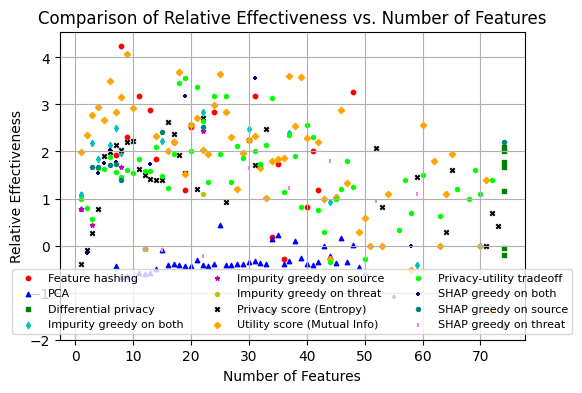

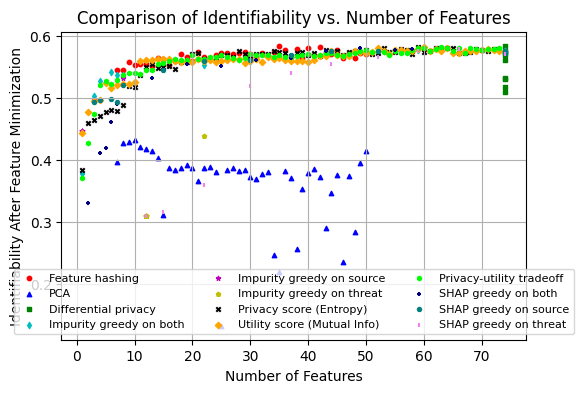

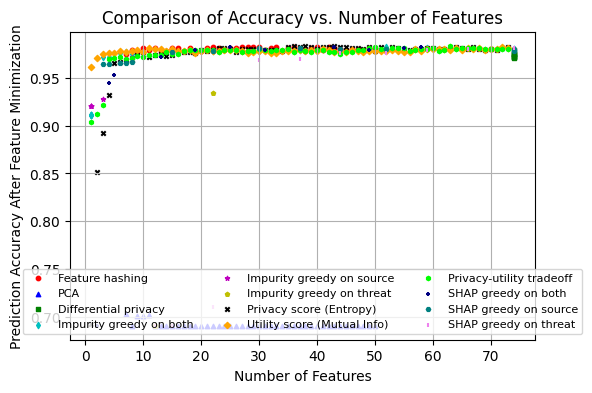

/tmp/ipykernel_1425891/1515238577.py:6: RuntimeWarning: invalid value encountered in log
  return np.log(numerator / denominator)
/tmp/ipykernel_1425891/1515238577.py:6: RuntimeWarning: divide by zero encountered in log
  return np.log(numerator / denominator)


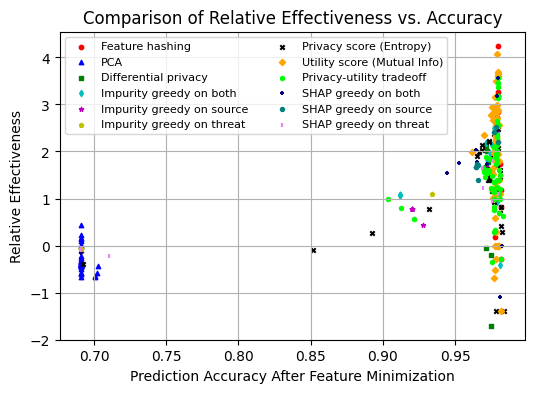

/tmp/ipykernel_1425891/1515238577.py:6: RuntimeWarning: invalid value encountered in log
  return np.log(numerator / denominator)
/tmp/ipykernel_1425891/1515238577.py:6: RuntimeWarning: divide by zero encountered in log
  return np.log(numerator / denominator)


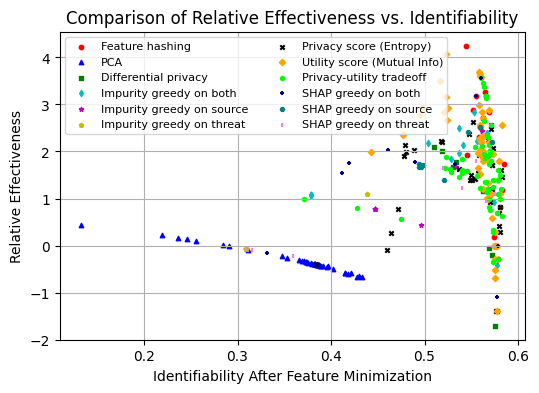

In [26]:
import numpy as np

score_list_fh = np.loadtxt(f'feature_hashing.csv', delimiter=",")
score_list_pca = np.loadtxt(f'pca_reduction.csv', delimiter=",")
score_list_dp = np.loadtxt(f'differential_privacy.csv', delimiter=",")
score_list_privacy = np.loadtxt(f'privacy-score.csv', delimiter=",")
score_list_utility = np.loadtxt(f'utility-score.csv', delimiter=",")
score_list_privacy_utility = np.loadtxt(f'privacy-utility.csv', delimiter=",")

custom_text='train size:1'
score_list_both = np.loadtxt(f'shap_{custom_text}.score_list_both.csv', delimiter=",")
score_list_source = np.loadtxt(f'shap_{custom_text}.score_list_source.csv', delimiter=",")
score_list_threat = np.loadtxt(f'shap_{custom_text}.score_list_threat.csv', delimiter=",")

score_list_impurity_both = np.loadtxt(f'impurity.score_list_both_random_forest.csv', delimiter=",")
score_list_impurity_source = np.loadtxt(f'impurity.score_list_source_random_forest.csv', delimiter=",")
score_list_impurity_threat = np.loadtxt(f'impurity.score_list_threat_random_forest.csv', delimiter=",")

score_lists = [score_list_fh[4:, :], score_list_pca[4:, :], score_list_dp,
               score_list_impurity_both, score_list_impurity_source, score_list_impurity_threat,
               score_list_privacy, score_list_utility, score_list_privacy_utility,
               score_list_both, score_list_source, score_list_threat,]
legend_lists = ['Feature hashing', 'PCA', 'Differential privacy',
                'Impurity greedy on both', 'Impurity greedy on source', 'Impurity greedy on threat',
                'Privacy score (Entropy)', 'Utility score (Mutual Info)', 'Privacy-utility tradeoff',
                'SHAP greedy on both', 'SHAP greedy on source', 'SHAP greedy on threat',]

plot_multiple_accuracies(score_lists, legend_lists)
plot_multiple_ident_features(score_lists, legend_lists)
plot_multiple_accuracy_features(score_lists, legend_lists)
plot_multiple_releff_accuracies(score_lists, legend_lists)
plot_multiple_releff_ident(score_lists, legend_lists)

In [56]:
import numpy as np
import matplotlib.pyplot as plt

def plot_absolute_accuracies(score_lists, base_accuracy, base_ident, methods):
    # Extract values
    num_features = [score_list[:, 0] for score_list in score_lists]
    accuracy = [base_accuracy - score_list[:, 1] for score_list in score_lists]
    ident_diff = [base_ident - score_list[:, 2] for score_list in score_lists]
    y_max = max(np.max(accuracy), np.max(ident_diff))

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Left y-axis for accuracy
    ax1.set_xlabel('Number of Features')
    ax1.set_ylabel('Accuracy Loss', color='tab:blue')
    dot_formats = ['o-', 's-', '^-']
    for n, a, d, m in zip(num_features, accuracy, dot_formats, methods):
        ax1.plot(n, a, d, color='tab:blue', label=m)
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_ylim(0, y_max)

    # Right y-axis for identification difference
    ax2 = ax1.twinx()
    ax2.set_ylabel('Identifiability Reduction', color='tab:red')
    dot_formats = ['o--', 's--', '^--']
    for n, i, d, m in zip(num_features, ident_diff, dot_formats, methods):
        ax2.plot(n, i, d, color='tab:red', label=m)
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.set_ylim(0, y_max)

    # Title and grid
    plt.title(f'# Features vs. Accuracy Loss & Identifiability Reduction')
    fig.tight_layout()
    plt.grid(True)
    plt.legend(loc='upper left', fontsize=8, ncol=1)

    # Save and show
    # plt.savefig(f'{legend_name}.png')
    plt.show()

def plot_absolute_accuracy(score_list, base_accuracy, base_ident, method=''):
    # Extract values
    num_features = score_list[:, 0]
    accuracy = base_accuracy - score_list[:, 1]
    ident_diff = base_ident - score_list[:, 2]
    # y_max = max(max(accuracy), max(ident_diff))
    y_max = 0.45

    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Left y-axis for accuracy
    ax1.set_xlabel('Number of Features')
    ax1.set_ylabel('Accuracy Loss', color='tab:blue')
    ax1.plot(num_features, accuracy, 'o-', color='tab:blue', label='Accuracy')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_ylim(0, y_max)

    # Right y-axis for identification difference
    ax2 = ax1.twinx()
    ax2.set_ylabel('Identifiability Reduction', color='tab:red')
    ax2.plot(num_features, ident_diff, 's-', color='tab:red', label='Identifiability Reduction')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.set_ylim(0, y_max)

    # Title and grid
    plt.title(f'# Features vs. Accuracy Loss & Identifiability Reduction ({method})', fontsize=8)
    fig.tight_layout()
    plt.grid(True)

    # Save and show
    plt.savefig(f'cic-ids-{method}.pdf')
    plt.show()



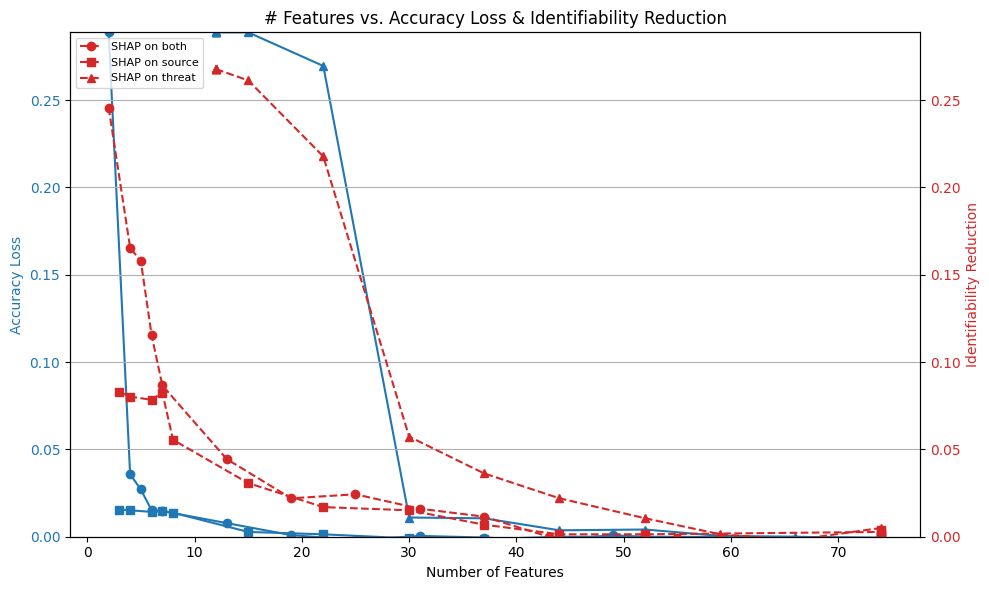

In [54]:
plot_absolute_accuracies([score_list_both, score_list_source, score_list_threat], base_acc, base_ident,
                         ['SHAP on both', 'SHAP on source', 'SHAP on threat'])

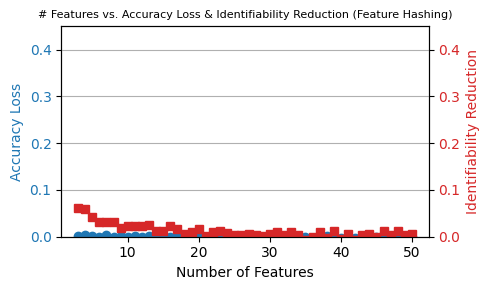

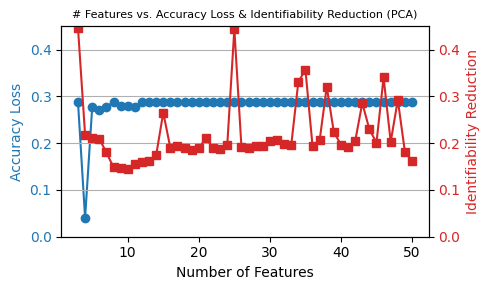

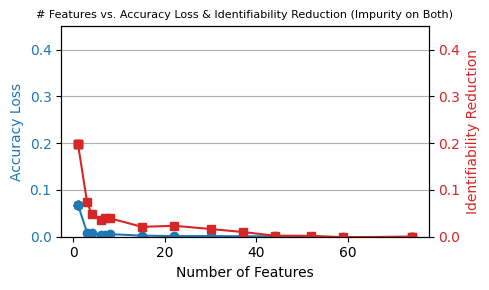

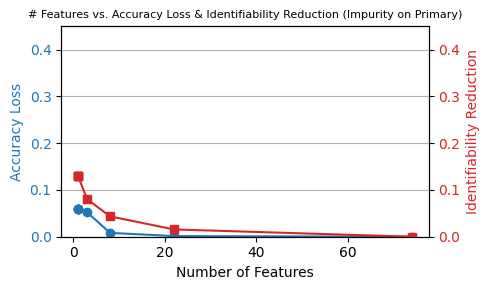

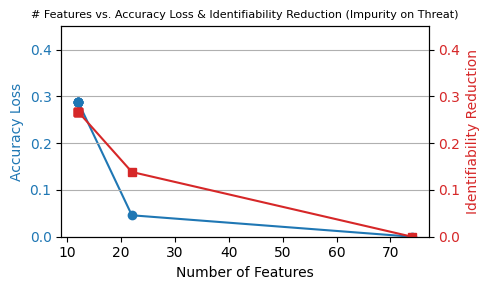

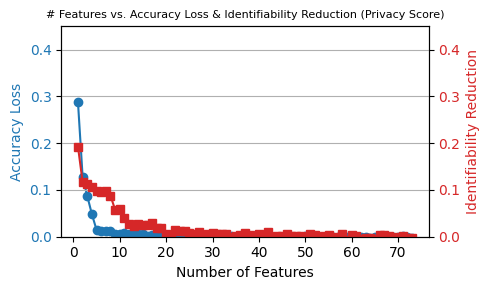

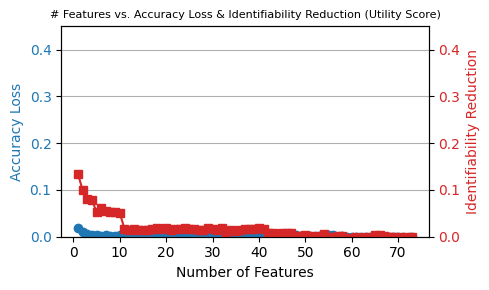

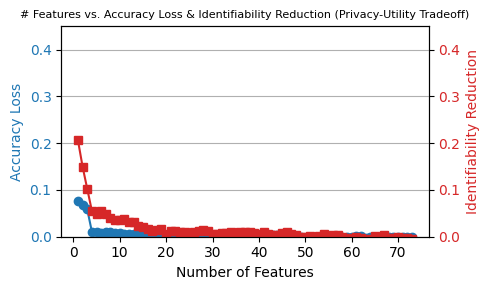

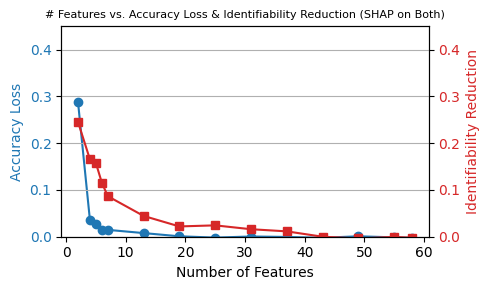

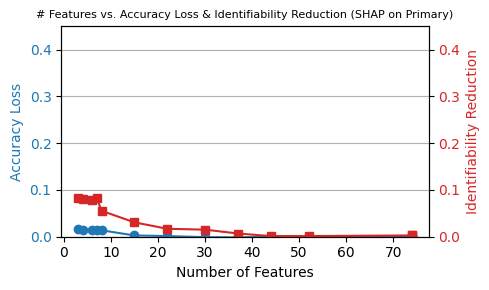

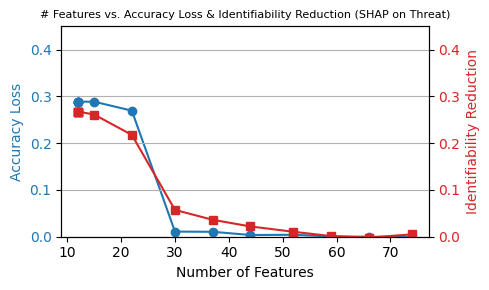

[None, None, None, None, None, None, None, None, None, None, None]

In [58]:

score_list_fh = np.loadtxt(f'feature_hashing.csv', delimiter=",")
score_list_pca = np.loadtxt(f'pca_reduction.csv', delimiter=",")
score_list_dp = np.loadtxt(f'differential_privacy.csv', delimiter=",")
score_list_privacy = np.loadtxt(f'privacy-score.csv', delimiter=",")
score_list_utility = np.loadtxt(f'utility-score.csv', delimiter=",")
score_list_privacy_utility = np.loadtxt(f'privacy-utility.csv', delimiter=",")

custom_text='train size:1'
score_list_both = np.loadtxt(f'shap_{custom_text}.score_list_both.csv', delimiter=",")
score_list_source = np.loadtxt(f'shap_{custom_text}.score_list_source.csv', delimiter=",")
score_list_threat = np.loadtxt(f'shap_{custom_text}.score_list_threat.csv', delimiter=",")

score_list_impurity_both = np.loadtxt(f'impurity.score_list_both_random_forest.csv', delimiter=",")
score_list_impurity_source = np.loadtxt(f'impurity.score_list_source_random_forest.csv', delimiter=",")
score_list_impurity_threat = np.loadtxt(f'impurity.score_list_threat_random_forest.csv', delimiter=",")


score_lists = [score_list_fh, score_list_pca, #score_list_dp,
               score_list_impurity_both, score_list_impurity_source, score_list_impurity_threat,
               score_list_privacy, score_list_utility, score_list_privacy_utility,
               score_list_both, score_list_source, score_list_threat,]

methods = ['Feature Hashing', 'PCA', 'Impurity on Both', 'Impurity on Primary', 'Impurity on Threat',
           'Privacy Score', 'Utility Score', 'Privacy-Utility Tradeoff', 'SHAP on Both', 'SHAP on Primary', 'SHAP on Threat']
[plot_absolute_accuracy(score_list, base_acc, base_ident, method) for score_list, method in zip(score_lists, methods)]
